In [1]:
!pip install odefinterp==0.1.22 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 67.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 71.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.4 MB/s eta

In [42]:
# !sudo apt-get install texlive-latex-extra

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-lato fonts-lmodern fonts-texgyre libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  libavalon-framework-java libcommons-logging-java-doc
  libexcalibur-logkit-java liblog4j1.2-java ri ruby-dev bundler debhelper
  perl-tk xpdf | pdf-viewer xzdec texlive-fonts-recommended-doc
  texlive-latex-base-doc python3-pygments icc-profiles libfile-which-perl
 

In [2]:
import odeformer
from scipy.integrate import solve_ivp
from odeformer.model import SymbolicTransformerRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import torch, json, os, sys, re, shutil
import numpy as np
from tqdm import tqdm
from itertools import combinations
from io import StringIO

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Gen. for 1D and 2D Systems

In [4]:
# ALL 1D AND 2D SYSTEMS (51 EQS.)

# ============================
# 1D SYSTEMS (23 systems)
# ============================

def rc_circuit(t, x, params):
    # RC-circuit (charging capacitor): dx/dt = (V - x)/tau
    V = params.get("V", 5.0)
    tau = params.get("tau", 1.0)
    return [ (V - x[0]) / tau ]

def population_growth(t, x, params):
    # Naive population growth: dx/dt = r * x
    r = params.get("r", 0.5)
    return [ r * x[0] ]

def logistic_growth(t, x, params):
    # Logistic growth: dx/dt = r * x * (1 - x/K)
    r = params.get("r", 1.0)
    K = params.get("K", 10.0)
    return [ r * x[0] * (1 - x[0]/K) ]

def rc_circuit_nonlinear(t, x, params):
    # RC-circuit with non-linear resistor: here we use a simple nonlinear term
    V = params.get("V", 5.0)
    return [ V - x[0]**2 ]

def falling_object(t, x, params):
    # Velocity of a falling object with air resistance: dv/dt = g - k*v^2
    g = params.get("g", 9.81)
    k = params.get("k", 0.1)
    return [ g - k * x[0]**2 ]

def autocatalysis(t, x, params):
    # Autocatalysis with one fixed abundant chemical: dx/dt = c0*x - c1*x^2
    c0 = params.get("c0", 2.1)
    c1 = params.get("c1", 0.5)
    return [ c0 * x[0] - c1 * x[0]**2 ]

def gompertz(t, x, params):
    # Gompertz law for tumor growth: dx/dt = c0*x*log(c1*x)
    c0 = params.get("c0", 0.032)
    c1 = params.get("c1", 2.29)
    return [ c0 * x[0] * np.log(c1 * x[0] + 1e-8) ]  # add epsilon for safety

def logistic_allee(t, x, params):
    # Logistic equation with Allee effect: dx/dt = r*x*(1 - x/K)*(x/A - 1)
    r = params.get("r", 0.14)
    K = params.get("K", 130.0)
    A = params.get("A", 4.4)
    return [ r * x[0] * (1 - x[0]/K) * (x[0]/A - 1) ]

def language_death(t, x, params):
    # Language death model for two languages: dx/dt = c0*(1-x) - c1*x
    c0 = params.get("c0", 0.32)
    c1 = params.get("c1", 0.28)
    return [ c0 * (1 - x[0]) - c1 * x[0] ]

def refined_language_death(t, x, params):
    # Refined language death model for two languages (illustrative form)
    c0 = params.get("c0", 0.2)
    c1 = params.get("c1", 1.2)
    # This is an example form; note that the true model may be more involved.
    return [ c0 * x[0]**(c1) * (1 - x[0]) - x[0] * (1 - c0) * (1 - x[0]) ]

def critical_slowing_down(t, x, params):
    # Naive critical slowing down (statistical mechanics): dx/dt = - x^3
    return [ - x[0]**3 ]

def laser_photons(t, x, params):
    # Photons in a laser (simple): dx/dt = c0*x - c1*x^2
    c0 = params.get("c0", 1.8)
    c1 = params.get("c1", 0.1107)
    return [ c0 * x[0] - c1 * x[0]**2 ]

def overdamped_bead(t, x, params):
    # Overdamped bead on a rotating hoop: dx/dt = c0*(c1*cos(x) - 1)*sin(x)
    c0 = params.get("c0", 0.0981)
    c1 = params.get("c1", 9.7)
    return [ c0 * (c1 * np.cos(x[0]) - 1) * np.sin(x[0]) ]

def budworm_predation(t, x, params):
    # Budworm outbreak model with predation: dx/dt = c0*x*(1 - x/c1) - c3*x^2
    c0 = params.get("c0", 0.78)
    c1 = params.get("c1", 81.0)
    c3 = params.get("c3", 21.2)
    return [ c0 * x[0] * (1 - x[0]/c1) - c3 * x[0]**2 ]

def budworm_predation_dimless(t, x, params):
    # Budworm outbreak with predation (dimensionless): a simplified form
    c0 = params.get("c0", 0.4)
    c1 = params.get("c1", 95.0)
    return [ c0 * x[0] * (1 - x[0]/c1) - x[0]**2 ]

def landau_equation(t, x, params):
    # Landau equation: dx/dt = c0*x - c1*x^3 - c2*x^5
    c0 = params.get("c0", 0.1)
    c1 = params.get("c1", -0.04)
    c2 = params.get("c2", 0.001)
    return [ c0 * x[0] - c1 * x[0]**3 - c2 * x[0]**5 ]

def logistic_harvesting(t, x, params):
    # Logistic equation with harvesting/fishing: dx/dt = c0*x*(1 - x/c1) - c2
    c0 = params.get("c0", 0.4)
    c1 = params.get("c1", 100.0)
    c2 = params.get("c2", 0.3)
    return [ c0 * x[0] * (1 - x[0]/c1) - c2 ]

def improved_logistic_harvesting(t, x, params):
    # Improved logistic equation with harvesting/fishing:
    c0 = params.get("c0", 0.4)
    c1 = params.get("c1", 100.0)
    c2 = params.get("c2", 0.24)
    c3 = params.get("c3", 50.0)
    return [ c0 * x[0] * (1 - x[0]/c1) - c2 * x[0] / (c3 + x[0]) ]

def improved_logistic_harvesting_dimless(t, x, params):
    # Improved logistic equation with harvesting/fishing (dimensionless)
    c0 = params.get("c0", 0.08)
    c1 = params.get("c1", 0.8)
    return [ - c0 * x[0] / (c1 + x[0]) + x[0] * (1 - x[0]) ]

def autocatalytic_gene_switching(t, x, params):
    # Autocatalytic gene switching (dimensionless): dx/dt = c0 - c1*x + x^2/(x+1)
    c0 = params.get("c0", 0.1)
    c1 = params.get("c1", 0.55)
    return [ c0 - c1 * x[0] + x[0]**2 / (x[0] + 1 + 1e-8) ]

def reduced_SIR_dead(t, x, params):
    # Dimensionally reduced SIR infection model for dead people (dimensionless): dx/dt = -c0*x - exp(-x)
    c0 = params.get("c0", 1.2)
    return [ - c0 * x[0] - np.exp(-x[0]) ]

def hysteretic_activation(t, x, params):
    # Hysteretic activation of a protein expression (positive feedback, basal promoter expression)
    c0 = params.get("c0", 1.4)
    c1 = params.get("c1", 0.4)
    c2 = params.get("c2", 123.0)
    c3 = params.get("c3", 0.89)
    return [ c0 + c1 * x[0]**5 / (c2 + x[0]**5) - c3 * x[0] ]

def overdamped_pendulum(t, x, params):
    # Overdamped pendulum with constant driving torque (dimensionless): dx/dt = c0 - sin(x)
    c0 = params.get("c0", 0.21)
    return [ c0 - np.sin(x[0]) ]

# Dictionary for 1D systems
systems_1d = {
    "RC-circuit": {
        "func": rc_circuit,
        "default_params": {"V": 5.0, "tau": 1.0},
        "default_ic": [0.0],
        "t_span": (0, 10)
    },
    "Population_growth": {
        "func": population_growth,
        "default_params": {"r": 0.5},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Logistic_growth": {
        "func": logistic_growth,
        "default_params": {"r": 1.0, "K": 10.0},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "RC-circuit_nonlinear": {
        "func": rc_circuit_nonlinear,
        "default_params": {"V": 5.0},
        "default_ic": [0.0],
        "t_span": (0, 10)
    },
    "Falling_object": {
        "func": falling_object,
        "default_params": {"g": 9.81, "k": 0.1},
        "default_ic": [0.0],
        "t_span": (0, 10)
    },
    "Autocatalysis": {
        "func": autocatalysis,
        "default_params": {"c0": 2.1, "c1": 0.5},
        "default_ic": [0.1],
        "t_span": (0, 10)
    },
    "Gompertz": {
        "func": gompertz,
        "default_params": {"c0": 0.032, "c1": 2.29},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Logistic_allee": {
        "func": logistic_allee,
        "default_params": {"r": 0.14, "K": 130.0, "A": 4.4},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Language_death": {
        "func": language_death,
        "default_params": {"c0": 0.32, "c1": 0.28},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Refined_language_death": {
        "func": refined_language_death,
        "default_params": {"c0": 0.2, "c1": 1.2},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Critical_slowing_down": {
        "func": critical_slowing_down,
        "default_params": {},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Laser_photons": {
        "func": laser_photons,
        "default_params": {"c0": 1.8, "c1": 0.1107},
        "default_ic": [10.0],
        "t_span": (0, 10)
    },
    "Overdamped_bead": {
        "func": overdamped_bead,
        "default_params": {"c0": 0.0981, "c1": 9.7},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Budworm_predation": {
        "func": budworm_predation,
        "default_params": {"c0": 0.78, "c1": 81.0, "c3": 21.2},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Budworm_predation_dimless": {
        "func": budworm_predation_dimless,
        "default_params": {"c0": 0.4, "c1": 95.0},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Landau_equation": {
        "func": landau_equation,
        "default_params": {"c0": 0.1, "c1": -0.04, "c2": 0.001},
        "default_ic": [0.1],
        "t_span": (0, 10)
    },
    "Logistic_harvesting": {
        "func": logistic_harvesting,
        "default_params": {"c0": 0.4, "c1": 100.0, "c2": 0.3},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Improved_logistic_harvesting": {
        "func": improved_logistic_harvesting,
        "default_params": {"c0": 0.4, "c1": 100.0, "c2": 0.24, "c3": 50.0},
        "default_ic": [1.0],
        "t_span": (0, 10)
    },
    "Improved_logistic_harvesting_dimless": {
        "func": improved_logistic_harvesting_dimless,
        "default_params": {"c0": 0.08, "c1": 0.8},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Autocatalytic_gene_switching": {
        "func": autocatalytic_gene_switching,
        "default_params": {"c0": 0.1, "c1": 0.55},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Reduced_SIR_dead": {
        "func": reduced_SIR_dead,
        "default_params": {"c0": 1.2},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Hysteretic_activation": {
        "func": hysteretic_activation,
        "default_params": {"c0": 1.4, "c1": 0.4, "c2": 123.0, "c3": 0.89},
        "default_ic": [0.5],
        "t_span": (0, 10)
    },
    "Overdamped_pendulum": {
        "func": overdamped_pendulum,
        "default_params": {"c0": 0.21},
        "default_ic": [0.0],
        "t_span": (0, 10)
    }
}

# ============================
# 2D SYSTEMS (28 systems)
# ============================

def harmonic_oscillator_no_damping(t, X, params):
    # Harmonic oscillator without damping: dx/dt = y, dy/dt = -omega^2 * x
    omega = params.get("omega", 1.0)
    return [ X[1], -omega**2 * X[0] ]

def harmonic_oscillator_damping(t, X, params):
    # Harmonic oscillator with damping: dx/dt = y, dy/dt = -omega^2 * x - d*y
    omega = params.get("omega", 1.0)
    d = params.get("d", 0.5)
    return [ X[1], -omega**2 * X[0] - d * X[1] ]

def lotka_volterra_competition(t, X, params):
    # Lotka-Volterra competition model: dx/dt = alpha*x - beta*x*y, dy/dt = delta*x*y - gamma*y
    alpha = params.get("alpha", 1.0)
    beta  = params.get("beta", 0.1)
    delta = params.get("delta", 0.075)
    gamma = params.get("gamma", 1.5)
    x, y = X
    return [ alpha*x - beta*x*y, delta*x*y - gamma*y ]

def lotka_volterra_simple(t, X, params):
    # Lotka-Volterra simple version (same form but parameters may differ)
    alpha = params.get("alpha", 1.84)
    beta  = params.get("beta", 1.45)
    gamma = params.get("gamma", 3.0)
    delta = params.get("delta", 1.62)
    x, y = X
    return [ alpha*x - beta*x*y, -gamma*y + delta*x*y ]

def pendulum_no_friction(t, X, params):
    # Pendulum without friction: dtheta/dt = omega, domega/dt = - (g/L)*sin(theta)
    g = params.get("g", 9.81)
    L = params.get("L", 1.0)
    theta, omega = X
    return [ omega, -(g/L)*np.sin(theta) ]

def dipole_fixed_point(t, X, params):
    # Dipole fixed point (illustrative dummy model)
    x, y = X
    return [ x*y - x, -x*y + y ]

def rna_replication(t, X, params):
    # RNA molecules catalyzing each other's replication (illustrative dummy model)
    c0 = params.get("c0", 1.61)
    x, y = X
    return [ -c0*x*y + 0.5, -c0*x*y + 0.5 ]

def SIR_model(t, X, params):
    # SIR infection model (only healthy and sick, dimensionless): let x = S, y = I
    beta = params.get("beta", 0.4)
    gamma = params.get("gamma", 0.314)
    S, I = X
    return [ -beta*S*I, beta*S*I - gamma*I ]

def damped_double_well(t, X, params):
    # Damped double well oscillator: dx/dt = y, dy/dt = -a*x - b*x^3 - c*y
    a = params.get("a", 0.18)
    b = params.get("b", 1.8)
    c = params.get("c", 1.8)
    return [ X[1], -a*X[0] - b*X[0]**3 - c*X[1] ]

def glider(t, X, params):
    # Glider (dimensionless): illustrative model
    c0 = params.get("c0", 0.08)
    return [ -c0*X[0]**2 - np.sin(X[1]), X[0] - np.cos(X[1]) ]

def frictionless_bead(t, X, params):
    # Frictionless bead on a rotating hoop (dimensionless): illustrative model
    return [ (np.cos(X[0]) - 1)*np.sin(X[0]), 0.0 ]

def rotational_dynamics(t, X, params):
    # Rotational dynamics in shear flow: illustrative model
    return [ np.cos(X[0]) / np.tan(X[1] + 1e-8), np.sin(X[0]) ]

def pendulum_nonlinear_damping(t, X, params):
    # Pendulum with non-linear damping, no driving (dimensionless)
    g = params.get("g", 9.81)
    L = params.get("L", 1.0)
    theta, omega = X
    return [ omega, -omega*np.cos(theta) - np.sin(theta) ]

def van_der_pol_standard(t, X, params):
    # Van der Pol oscillator (standard form): dx/dt = y, dy/dt = mu*(1 - x^2)*y - x
    mu = params.get("mu", 0.43)
    return [ X[1], mu*(1 - X[0]**2)*X[1] - X[0] ]

def van_der_pol_simplified(t, X, params):
    # Van der Pol oscillator (simplified form from Strogatz): same structure with a different mu
    mu = params.get("mu", 3.37)
    return [ X[1], mu*(1 - X[0]**2)*X[1] - X[0] ]

def glycolytic_oscillator(t, X, params):
    # Glycolytic oscillator (dimensionless): illustrative form
    c0 = params.get("c0", 2.4)
    c1 = params.get("c1", 0.07)
    return [ c0*X[1] + X[0]*X[1] - X[0], -c0*X[0] + c1 - X[1]**2 ]

def duffing_equation(t, X, params):
    # Duffing equation (weakly non-linear oscillation): dx/dt = y, dy/dt = -c0*y*(1 - x^2) - x
    c0 = params.get("c0", 0.886)
    return [ X[1], -c0*X[1]*(1 - X[0]**2) - X[0] ]

def cell_cycle_tyson(t, X, params):
    # Cell cycle model by Tyson (dimensionless): illustrative dummy model
    c0 = params.get("c0", 15.3)
    c1 = params.get("c1", 0.001)
    c2 = params.get("c2", 0.3)
    x, y = X
    return [ c0*(1 - x) - c1*x*y, c2*x*y - x*y ]

def chlorine_dioxide_model(t, X, params):
    # Reduced model for chlorine dioxide-iodine-malonic acid reaction (dimensionless): dummy form
    c0 = params.get("c0", 8.9)
    c1 = params.get("c1", 4.0)
    c2 = params.get("c2", 1.4)
    x, y = X
    return [ c0 - c1*x*y/(x+1), -x + c2 ]

def driven_pendulum_linear(t, X, params):
    # Driven pendulum with linear damping / Josephson junction (dimensionless): dtheta/dt = omega, domega/dt = c0 - c1*omega - sin(theta)
    c0 = params.get("c0", 1.67)
    c1 = params.get("c1", 0.64)
    theta, omega = X
    return [ omega, c0 - c1*omega - np.sin(theta) ]

def driven_pendulum_quadratic(t, X, params):
    # Driven pendulum with quadratic damping (dimensionless)
    c0 = params.get("c0", 1.67)
    c1 = params.get("c1", 0.64)
    theta, omega = X
    return [ omega, c0 - c1*omega*abs(omega) - np.sin(theta) ]

def isothermal_autocatalytic(t, X, params):
    # Isothermal autocatalytic reaction model by Gray and Scott 1985 (dimensionless)
    c0 = params.get("c0", 0.5)
    c1 = params.get("c1", 0.02)
    x, y = X
    return [ c0*(1 - x) - x*y**2, x*y**2 - (c1 + y)*y ]

def interacting_bar_magnets(t, X, params):
    # Interacting bar magnets (dimensionless)
    c0 = params.get("c0", 0.33)
    x, y = X
    return [ c0*np.sin(x - y) - np.sin(x), -c0*np.sin(x - y) - np.sin(y) ]

def binocular_rivalry(t, X, params):
    # Binocular rivalry model (no oscillations): dummy form
    return [ -X[0] + 1/np.exp(X[1] + 1e-8), -X[1] + 1/np.exp(X[0] + 1e-8) ]

def bacterial_respiration(t, X, params):
    # Bacterial respiration model for nutrients and oxygen levels
    c0 = params.get("c0", 18.3)
    c1 = params.get("c1", 0.48)
    c2 = params.get("c2", 11.23)
    x, y = X
    return [ c0 - (x*y)/c1, -x + c2 ]

def brusselator(t, X, params):
    # Brusselator (dimensionless)
    c0 = params.get("c0", 1.0)
    c1 = params.get("c1", 1.0)
    x, y = X
    return [ c0 + x**2 * y - (c1+1)*x, c1*x - x**2 * y ]

def schnackenberg_oscillator(t, X, params):
    # Chemical oscillator model by Schnackenberg 1979 (dimensionless)
    c0 = params.get("c0", 0.65)
    c1 = params.get("c1", 3.37)
    x, y = X
    return [ c0 - x + x**2 * y, c1 - x**2 * y ]

def oscillator_death(t, X, params):
    # Oscillator death model by Ermentrout and Kopell 1990 (dimensionless)
    c0 = params.get("c0", 1.0)
    c1 = params.get("c1", 1.0)
    x, y = X
    return [ c0 + np.sin(x) - y, c1 + np.cos(x) - y ]

# Dictionary for 2D systems
systems_2d = {
    "Harmonic_oscillator_no_damping": {
        "func": harmonic_oscillator_no_damping,
        "default_params": {"omega": 1.0},
        "default_ic": [1.0, 0.0],
        "t_span": (0, 10)
    },
    "Harmonic_oscillator_damping": {
        "func": harmonic_oscillator_damping,
        "default_params": {"omega": 1.0, "d": 0.5},
        "default_ic": [1.0, 0.0],
        "t_span": (0, 10)
    },
    "Lotka_Volterra_competition": {
        "func": lotka_volterra_competition,
        "default_params": {"alpha": 1.0, "beta": 0.1, "delta": 0.075, "gamma": 1.5},
        "default_ic": [10.0, 5.0],
        "t_span": (0, 30)
    },
    "Lotka_Volterra_simple": {
        "func": lotka_volterra_simple,
        "default_params": {"alpha": 1.84, "beta": 1.45, "gamma": 3.0, "delta": 1.62},
        "default_ic": [8.3, 3.4],
        "t_span": (0, 30)
    },
    "Pendulum_no_friction": {
        "func": pendulum_no_friction,
        "default_params": {"g": 9.81, "L": 1.0},
        "default_ic": [0.5, 0.0],
        "t_span": (0, 10)
    },
    "Dipole_fixed_point": {
        "func": dipole_fixed_point,
        "default_params": {},
        "default_ic": [3.2, 1.4],
        "t_span": (0, 10)
    },
    "RNA_replication": {
        "func": rna_replication,
        "default_params": {"c0": 1.61},
        "default_ic": [0.3, 0.04],
        "t_span": (0, 10)
    },
    "SIR_model": {
        "func": SIR_model,
        "default_params": {"beta": 0.4, "gamma": 0.314},
        "default_ic": [7.2, 0.98],
        "t_span": (0, 10)
    },
    "Damped_double_well": {
        "func": damped_double_well,
        "default_params": {"a": 0.18, "b": 1.8, "c": 1.8},
        "default_ic": [-1.8, -1.8],
        "t_span": (0, 10)
    },
    "Glider": {
        "func": glider,
        "default_params": {"c0": 0.08},
        "default_ic": [5.0, 0.7],
        "t_span": (0, 10)
    },
    "Frictionless_bead": {
        "func": frictionless_bead,
        "default_params": {},
        "default_ic": [2.1, 0.0],
        "t_span": (0, 10)
    },
    "Rotational_dynamics": {
        "func": rotational_dynamics,
        "default_params": {},
        "default_ic": [1.13, 1.7],
        "t_span": (0, 10)
    },
    "Pendulum_nonlinear_damping": {
        "func": pendulum_nonlinear_damping,
        "default_params": {"g": 9.81, "L": 1.0},
        "default_ic": [0.45, 0.9],
        "t_span": (0, 10)
    },
    "Van_der_Pol_standard": {
        "func": van_der_pol_standard,
        "default_params": {"mu": 0.43},
        "default_ic": [2.2, 0.0],
        "t_span": (0, 10)
    },
    "Van_der_Pol_simplified": {
        "func": van_der_pol_simplified,
        "default_params": {"mu": 0.7},
        "default_ic": [0.7, 0.0],
        "t_span": (0, 10)
    },
    "Glycolytic_oscillator": {
        "func": glycolytic_oscillator,
        "default_params": {"c0": 2.4, "c1": 0.07},
        "default_ic": [0.4, -0.7],
        "t_span": (0, 10)
    },
    "Duffing_equation": {
        "func": duffing_equation,
        "default_params": {"c0": 0.63},
        "default_ic": [0.2, 0.2],
        "t_span": (0, 10)
    },
    "Cell_cycle_tyson": {
        "func": cell_cycle_tyson,
        "default_params": {"c0": 15.3, "c1": 0.001, "c2": 0.3},
        "default_ic": [0.8, 0.3],
        "t_span": (0, 10)
    },
    "Chlorine_dioxide_model": {
        "func": chlorine_dioxide_model,
        "default_params": {"c0": 8.9, "c1": 4.0, "c2": 1.4},
        "default_ic": [0.2, 0.35],
        "t_span": (0, 10)
    },
    "Driven_pendulum_linear": {
        "func": driven_pendulum_linear,
        "default_params": {"c0": 1.67, "c1": 0.64},
        "default_ic": [1.47, -0.2],
        "t_span": (0, 10)
    },
    "Driven_pendulum_quadratic": {
        "func": driven_pendulum_quadratic,
        "default_params": {"c0": 1.67, "c1": 0.64},
        "default_ic": [1.47, -0.2],
        "t_span": (0, 10)
    },
    "Isothermal_autocatalytic": {
        "func": isothermal_autocatalytic,
        "default_params": {"c0": 0.5, "c1": 0.02},
        "default_ic": [1.4, 0.2],
        "t_span": (0, 10)
    },
    "Interacting_bar_magnets": {
        "func": interacting_bar_magnets,
        "default_params": {"c0": 0.33},
        "default_ic": [0.54, -0.1],
        "t_span": (0, 10)
    },
    "Binocular_rivalry": {
        "func": binocular_rivalry,
        "default_params": {},
        "default_ic": [0.65, 0.59],
        "t_span": (0, 10)
    },
    "Bacterial_respiration": {
        "func": bacterial_respiration,
        "default_params": {"c0": 18.3, "c1": 0.48, "c2": 11.23},
        "default_ic": [0.1, 30.4],
        "t_span": (0, 10)
    },
    "Brusselator": {
        "func": brusselator,
        "default_params": {"c0": 1.0, "c1": 1.0},
        "default_ic": [1.0, 1.0],
        "t_span": (0, 10)
    },
    "Schnackenberg_oscillator": {
        "func": schnackenberg_oscillator,
        "default_params": {"c0": 0.65, "c1": 3.37},
        "default_ic": [1.0, 1.0],
        "t_span": (0, 10)
    },
    "Oscillator_death": {
        "func": oscillator_death,
        "default_params": {"c0": 1.0, "c1": 1.0},
        "default_ic": [0.0, 0.0],
        "t_span": (0, 10)
    }
}

# ============================
# UTILITY: GENERATE TRAJECTORY
# ============================

def generate_trajectory(ode_func, initial_condition, params, t_span, t_eval):
    sol = solve_ivp(fun=lambda t, y: ode_func(t, y, params),
                    t_span=t_span,
                    y0=initial_condition,
                    t_eval=t_eval,
                    vectorized=False)
    return sol.t, sol.y

# ============================
# PLOTTING FUNCTION
# ============================

def plot_trajectory(t, y, system_name):
    plt.figure()
    if y.shape[0] == 1:
        # 1D system
        plt.plot(t, y[0], label=system_name)
        plt.xlabel("Time")
        plt.ylabel("x(t)")
    else:
        # 2D system: plot each state versus time
        for i in range(y.shape[0]):
            plt.plot(t, y[i], label=f"state {i+1}")
        plt.xlabel("Time")
        plt.ylabel("State")
    plt.title(f"Trajectory for {system_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
# Updated all systems with LaTeX equations

systems_1d["RC-circuit"]["equation"] = [r"\frac{dx}{dt} = \frac{V - x}{\tau}"]
systems_1d["Population_growth"]["equation"] = [r"\frac{dx}{dt} = r x"]
systems_1d["Logistic_growth"]["equation"] = [r"\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right)"]
systems_1d["RC-circuit_nonlinear"]["equation"] = [r"\frac{dx}{dt} = V - x^2"]
systems_1d["Falling_object"]["equation"] = [r"\frac{dv}{dt} = g - k v^2"]
systems_1d["Autocatalysis"]["equation"] = [r"\frac{dx}{dt} = c_0 x - c_1 x^2"]
systems_1d["Gompertz"]["equation"] = [r"\frac{dx}{dt} = c_0 x \ln(c_1 x)"]
systems_1d["Logistic_allee"]["equation"] = [r"\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right)\left(\frac{x}{A} - 1\right)"]
systems_1d["Language_death"]["equation"] = [r"\frac{dx}{dt} = c_0(1 - x) - c_1 x"]
systems_1d["Refined_language_death"]["equation"] = [r"\frac{dx}{dt} = c_0 x^{c_1} (1 - x) - x (1 - c_0) (1 - x)"]
systems_1d["Critical_slowing_down"]["equation"] = [r"\frac{dx}{dt} = -x^3"]
systems_1d["Laser_photons"]["equation"] = [r"\frac{dx}{dt} = c_0 x - c_1 x^2"]
systems_1d["Overdamped_bead"]["equation"] = [r"\frac{dx}{dt} = c_0 (c_1 \cos(x) - 1) \sin(x)"]
systems_1d["Budworm_predation"]["equation"] = [r"\frac{dx}{dt} = c_0 x \left(1 - \frac{x}{c_1}\right) - c_3 x^2"]
systems_1d["Budworm_predation_dimless"]["equation"] = [r"\frac{dx}{dt} = c_0 x \left(1 - \frac{x}{c_1}\right) - x^2"]
systems_1d["Landau_equation"]["equation"] = [r"\frac{dx}{dt} = c_0 x - c_1 x^3 - c_2 x^5"]
systems_1d["Logistic_harvesting"]["equation"] = [r"\frac{dx}{dt} = c_0 x \left(1 - \frac{x}{c_1}\right) - c_2"]
systems_1d["Improved_logistic_harvesting"]["equation"] = [r"\frac{dx}{dt} = c_0 x \left(1 - \frac{x}{c_1}\right) - \frac{c_2 x}{c_3 + x}"]
systems_1d["Improved_logistic_harvesting_dimless"]["equation"] = [r"\frac{dx}{dt} = -\frac{c_0 x}{c_1 + x} + x (1 - x)"]
systems_1d["Autocatalytic_gene_switching"]["equation"] = [r"\frac{dx}{dt} = c_0 - c_1 x + \frac{x^2}{x + 1}"]
systems_1d["Reduced_SIR_dead"]["equation"] = [r"\frac{dx}{dt} = -c_0 x - e^{-x}"]
systems_1d["Hysteretic_activation"]["equation"] = [r"\frac{dx}{dt} = c_0 + \frac{c_1 x^5}{c_2 + x^5} - c_3 x"]
systems_1d["Overdamped_pendulum"]["equation"] = [r"\frac{dx}{dt} = c_0 - \sin(x)"]

systems_2d["Harmonic_oscillator_no_damping"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = -\omega^2 x"
]
systems_2d["Harmonic_oscillator_damping"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = -\omega^2 x - d y"
]
systems_2d["Lotka_Volterra_competition"]["equation"] = [
    r"\frac{dx}{dt} = \alpha x - \beta x y", 
    r"\frac{dy}{dt} = \delta x y - \gamma y"
]
systems_2d["Lotka_Volterra_simple"]["equation"] = [
    r"\frac{dx}{dt} = \alpha x - \beta x y", 
    r"\frac{dy}{dt} = -\gamma y + \delta x y"
]
systems_2d["Pendulum_no_friction"]["equation"] = [
    r"\frac{d\theta}{dt} = \omega", 
    r"\frac{d\omega}{dt} = -\frac{g}{L} \sin(\theta)"
]
systems_2d["Dipole_fixed_point"]["equation"] = [
    r"\frac{dx}{dt} = x y - x", 
    r"\frac{dy}{dt} = -x y + y"
]
systems_2d["RNA_replication"]["equation"] = [
    r"\frac{dx}{dt} = -c_0 x y + 0.5", 
    r"\frac{dy}{dt} = -c_0 x y + 0.5"
]
systems_2d["SIR_model"]["equation"] = [
    r"\frac{dS}{dt} = -\beta S I", 
    r"\frac{dI}{dt} = \beta S I - \gamma I"
]
systems_2d["Damped_double_well"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = -a x - b x^3 - c y"
]
systems_2d["Glider"]["equation"] = [
    r"\frac{dx}{dt} = -c_0 x^2 - \sin(y)", 
    r"\frac{dy}{dt} = x - \cos(y)"
]
systems_2d["Frictionless_bead"]["equation"] = [
    r"\frac{dx}{dt} = (\cos(x) - 1)\sin(x)", 
    r"\frac{dy}{dt} = 0"
]
systems_2d["Rotational_dynamics"]["equation"] = [
    r"\frac{dx}{dt} = \frac{\cos(x)}{\tan(y)}", 
    r"\frac{dy}{dt} = \sin(x)"
]
systems_2d["Pendulum_nonlinear_damping"]["equation"] = [
    r"\frac{d\theta}{dt} = \omega", 
    r"\frac{d\omega}{dt} = -\omega \cos(\theta) - \sin(\theta)"
]
systems_2d["Van_der_Pol_standard"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = \mu (1 - x^2) y - x"
]
systems_2d["Van_der_Pol_simplified"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = \mu (1 - x^2) y - x"
]
systems_2d["Glycolytic_oscillator"]["equation"] = [
    r"\frac{dx}{dt} = c_0 y + x y - x", 
    r"\frac{dy}{dt} = -c_0 x + c_1 - y^2"
]
systems_2d["Duffing_equation"]["equation"] = [
    r"\frac{dx}{dt} = y", 
    r"\frac{dy}{dt} = -c_0 y (1 - x^2) - x"
]
systems_2d["Cell_cycle_tyson"]["equation"] = [
    r"\frac{dx}{dt} = c_0 (1 - x) - c_1 x y", 
    r"\frac{dy}{dt} = c_2 x y - x y"
]
systems_2d["Chlorine_dioxide_model"]["equation"] = [
    r"\frac{dx}{dt} = c_0 - \frac{c_1 x y}{x + 1}", 
    r"\frac{dy}{dt} = -x + c_2"
]
systems_2d["Driven_pendulum_linear"]["equation"] = [
    r"\frac{d\theta}{dt} = \omega", 
    r"\frac{d\omega}{dt} = c_0 - c_1 \omega - \sin(\theta)"
]
systems_2d["Driven_pendulum_quadratic"]["equation"] = [
    r"\frac{d\theta}{dt} = \omega", 
    r"\frac{d\omega}{dt} = c_0 - c_1 \omega |\omega| - \sin(\theta)"
]
systems_2d["Isothermal_autocatalytic"]["equation"] = [
    r"\frac{dx}{dt} = c_0 (1 - x) - x y^2", 
    r"\frac{dy}{dt} = x y^2 - (c_1 + y) y"
]
systems_2d["Interacting_bar_magnets"]["equation"] = [
    r"\frac{dx}{dt} = c_0 \sin(x - y) - \sin(x)", 
    r"\frac{dy}{dt} = -c_0 \sin(x - y) - \sin(y)"
]
systems_2d["Binocular_rivalry"]["equation"] = [
    r"\frac{dx}{dt} = -x + \frac{1}{e^y}", 
    r"\frac{dy}{dt} = -y + \frac{1}{e^x}"
]
systems_2d["Bacterial_respiration"]["equation"] = [
    r"\frac{dx}{dt} = c_0 - \frac{x y}{c_1}", 
    r"\frac{dy}{dt} = -x + c_2"
]
systems_2d["Brusselator"]["equation"] = [
    r"\frac{dx}{dt} = c_0 + x^2 y - (c_1 + 1) x", 
    r"\frac{dy}{dt} = c_1 x - x^2 y"
]
systems_2d["Schnackenberg_oscillator"]["equation"] = [
    r"\frac{dx}{dt} = c_0 - x + x^2 y", 
    r"\frac{dy}{dt} = c_1 - x^2 y"
]
systems_2d["Oscillator_death"]["equation"] = [
    r"\frac{dx}{dt} = c_0 + \sin(x) - y", 
    r"\frac{dy}{dt} = c_1 + \cos(x) - y"
]

In [6]:
len(systems_1d), len(systems_2d)

(23, 28)

## Cross-Attns, Enc Self-Attns, and Enc Ablation Plots

In [7]:
def process_system(system_name, system_def, save_dir, t_eval=np.linspace(0, 10, 50)):
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate trajectory
    t, y = generate_trajectory(
        ode_func=system_def["func"],
        initial_condition=system_def["default_ic"],
        params=system_def["default_params"],
        t_span=system_def["t_span"],
        t_eval=t_eval
    )
    trajectory = y.T  # Convert to [time, features] shape

    # Initialize model
    dstr = SymbolicTransformerRegressor(from_pretrained=True, plot_token_charts=False)
    dstr.set_model_args({'beam_size': 5, 'beam_temperature': 0.1})
    dstr.fit(t, trajectory)
    dstr.print(n_predictions=1)

    # old_stdout = sys.stdout
    # sys.stdout = buffer = StringIO()
    # dstr.print(n_predictions=1)
    # sys.stdout = old_stdout
    # print(str(buffer.getvalue()))

    # with open(save_dir+"output.txt", 'w') as file:
    #     file.write("This is a line of text.\n")

    # 1. Create equation comparison plot
    # if "equation" in system_def:
    #     # Capture predicted equations
    #     old_stdout = sys.stdout
    #     sys.stdout = buffer = StringIO()
    #     dstr.print(n_predictions=1)
    #     sys.stdout = old_stdout
    #     predicted_eqs = parse_predicted_equations(buffer.getvalue())
        
    #     create_equation_summary(
    #         eq_generating=system_def["equation"],
    #         eq_predicted=predicted_eqs,
    #         system_name=system_name,
    #         save_dir=save_dir
    #     )

    # 2. Process attention mechanisms
    all_attentions = dstr.get_stored_attentions()
    intermediate_tokens = list(dstr.get_intermediate_tokens().values())
    
    # Process cross attentions
    process_cross_attentions(
        all_attentions, intermediate_tokens, t, trajectory, 
        system_name, save_dir
    )
    
    # Process encoder attentions
    if "encoder" in all_attentions:
        encoder_attn = torch.tensor(all_attentions["encoder"])
        process_encoder_attentions(
            encoder_attn, t, trajectory, 
            system_name, save_dir
        )

    # 3. Process encoder ablation studies
    process_encoder_ablation(t, trajectory, system_name, save_dir)

    # 4. Just show which system we processed
    plot_trajectory(t, y, system_name)

def process_cross_attentions(all_attentions, intermediate_tokens, times, trajectory, 
                            system_name, save_dir):
    """Process and save decoder cross-attention visualizations"""
    # Prepare data
    tokens_range = (0, len(intermediate_tokens))
    token_ids = range(*tokens_range)
    ytick_labels = [t[-1][1][-1] for t in intermediate_tokens]
    
    # Stack cross-attentions
    cross_attns = []
    for tid in token_ids:
        cross_attns.append(torch.tensor(all_attentions[f"token_{tid}"]["cross_attention"]))
    stacked = torch.cat(cross_attns, dim=3)  # [layers, beam, heads, tokens, seq]

    # Generate plots for each decoder layer
    for layer_idx in range(stacked.shape[0]):
        fig = plt.figure(figsize=(24, 20))
        gs = fig.add_gridspec(5, 4, height_ratios=[1]*5)
        
        # Get layer data and plot
        layer_data = stacked[layer_idx, 0]  # [heads, tokens, seq]
        plot_cross_attention(fig, gs, layer_data, times, trajectory, 
                            ytick_labels, f"Decoder Layer {layer_idx} ({system_name})")
        
        plt.savefig(os.path.join(save_dir, f"{system_name}_cross_attn_layer_{layer_idx}.png"))
        plt.close()

def plot_cross_attention(fig, gs, layer_data, times, trajectory, ytick_labels, title):
    """Helper to plot cross-attention matrices"""
    # Create axis labels
    xtick_labels = [f"t={t:.1f}\n" + "\n".join([f"x{i}={v:.2f}" 
                    for i, v in enumerate(point)]) 
                    for t, point in zip(times, trajectory)]
    
    # Plot summary
    ax1 = fig.add_subplot(gs[0, :])
    sum_attn = layer_data.sum(0).numpy()
    if sum_attn.max() > 0:
        sum_attn /= sum_attn.max()
    im = ax1.imshow(sum_attn, cmap='viridis', aspect='auto')
    ax1.set_title(f"{title} - Sum of All Heads")
    set_ticks(ax1, times, xtick_labels, ytick_labels)
    
    # Plot individual heads
    for head_idx in range(layer_data.shape[0]):
        ax = fig.add_subplot(gs[(head_idx//4)+1, head_idx%4])
        head_attn = layer_data[head_idx].numpy()
        if head_attn.max() > 0:
            head_attn /= head_attn.max()
        ax.imshow(head_attn, cmap='viridis', aspect='auto')
        ax.set_title(f"Head {head_idx}")
        set_ticks(ax, times, xtick_labels, ytick_labels, sparse=True)

def process_encoder_attentions(encoder_attn, times, trajectory, system_name, save_dir):
    """Process and save encoder self-attention visualizations"""
    encoder_attn = encoder_attn.squeeze(1)  # Remove beam dimension
    
    for layer_idx in range(encoder_attn.shape[0]):
        fig = plt.figure(figsize=(24, 18))
        gs = fig.add_gridspec(5, 4, height_ratios=[1]*5)
        
        layer_data = encoder_attn[layer_idx]  # [heads, seq, seq]
        plot_encoder_attention(fig, gs, layer_data, times, trajectory, 
                              f"Encoder Layer {layer_idx} ({system_name})")
        
        plt.savefig(os.path.join(save_dir, f"{system_name}_encoder_attn_layer_{layer_idx}.png"))
        plt.close()

def plot_encoder_attention(fig, gs, layer_data, times, trajectory, title):
    """Helper to plot encoder self-attention matrices"""
    xtick_labels = [f"t={t:.1f}\n" + "\n".join([f"x{i}={v:.2f}" 
                    for i, v in enumerate(point)]) 
                    for t, point in zip(times, trajectory)]
    
    # Plot summary
    ax1 = fig.add_subplot(gs[0, :])
    sum_attn = layer_data.sum(0).cpu().numpy()
    if sum_attn.max() > 0:
        sum_attn /= sum_attn.max()
    im = ax1.imshow(sum_attn, cmap='viridis', aspect='auto')
    ax1.set_title(f"{title} - Sum of All Heads")
    set_ticks(ax1, times, xtick_labels, xtick_labels)
    
    # Plot individual heads
    for head_idx in range(layer_data.shape[0]):
        ax = fig.add_subplot(gs[(head_idx//4)+1, head_idx%4])
        head_attn = layer_data[head_idx].cpu().numpy()
        if head_attn.max() > 0:
            head_attn /= head_attn.max()
        ax.imshow(head_attn, cmap='viridis', aspect='auto')
        ax.set_title(f"Head {head_idx}")
        set_ticks(ax, times, xtick_labels, xtick_labels, sparse=True)

def process_encoder_ablation(times, trajectory, system_name, save_dir):
    """Process encoder layer removal experiments"""
    encoder_layers = [0, 1, 2]  # Update based on your model architecture
    all_combos = [list(comb) for r in range(len(encoder_layers)+1) 
                 for comb in combinations(encoder_layers, r)]
    
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, layers in enumerate(all_combos):
        try:
            dstr = SymbolicTransformerRegressor(
                from_pretrained=True,
                ignore_enc_layers=layers,
                plot_token_charts=False,
                store_attentions=False
            )
            dstr.set_model_args({'beam_size': 2, 'beam_temperature': 0.1})
            dstr.fit(times, trajectory)
            pred = dstr.predict(times, trajectory[0])
            
            # Plot results
            ax = axes[i]
            for var_idx in range(trajectory.shape[1]):
                ax.plot(times, trajectory[:, var_idx], label=f'True {var_idx}')
                ax.plot(times, pred[:, var_idx], '--', label=f'Pred {var_idx}')
            ax.set_title(f"Removed: {layers}")
            ax.legend()
        except Exception as e:
            print(f"Error with layers {layers}: {e}")
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{system_name}_encoder_ablation.png"))
    plt.close()

def set_ticks(ax, times, xlabels, ylabels, sparse=False):
    """Helper to format plot ticks"""
    step = 4 if sparse else 2
    ax.set_xticks(np.arange(len(times))[::step])
    ax.set_xticklabels(xlabels[::step], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(ylabels))[::step])
    ax.set_yticklabels(ylabels[::step])
    
def create_equation_summary(eq_generating, eq_predicted, system_name, save_dir):
    """Create equation comparison using Matplotlib's Mathtext"""
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    
    # Format equations with markdown-style math
    gen_eqs = "\n".join([f"${md_math_convert(eq)}$" for eq in eq_generating])
    pred_eqs = "\n".join([f"${md_math_convert(eq)}$" for eq in eq_predicted])
    
    text_content = (
        "**Original System**\n" + gen_eqs + "\n\n" +
        "**Predicted System**\n" + pred_eqs
    )

    plt.text(0.05, 0.5, text_content, 
             fontsize=12, va='center', ha='left', 
             usetex=False,  # Crucial: disable LaTeX
             transform=plt.gcf().transFigure,
             wrap=True)
    
    plt.savefig(os.path.join(save_dir, f"{system_name}_equations.png"), 
                bbox_inches='tight')
    plt.close()

def md_math_convert(text):
    """Convert equations to Mathtext-compatible format"""
    replacements = {
        r'\frac{([^}]+)}{([^}]+)}': r'\dfrac{\1}{\2}',
        r'\^': '^',  # Handle exponents
        r'\balpha\b': 'α',
        r'\bbeta\b': 'β',
        r'\bgamma\b': 'γ',
        r'\bdelta\b': 'δ',
        # Add other Greek letters as needed
        r'\bexp\b': 'exp',
        r'\bln\b': 'ln',
        r'\bsin\b': 'sin',
        r'\bcos\b': 'cos',
        'lp': 'lp',  # Just render raw text
        '_': ' ',
    }
    
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)
    
    return text

def parse_predicted_equations(output_text):
    """Parse model output into plain text equations for matplotlib mathtext"""
    equations = []
    current_eq = []
    in_equation = False
    
    # Extract raw equation strings
    for line in output_text.split('\n'):
        if 'Predicted symbolic expression' in line:
            in_equation = True
            current_eq = []
        elif in_equation:
            if line.strip() == '':
                in_equation = False
                equations.append(' '.join(current_eq))
            else:
                current_eq.append(line.strip())
    
    # Convert to mathtext-friendly format
    cleaned_eqs = []
    for eq in equations:
        # Basic cleanup
        eq = eq.replace('**', '^')  # Exponents
        eq = eq.replace('*', ' ')    # Remove multiplication symbols
        eq = re.sub(r'\bexp\(([^)]+)\)', r'e^{\1}', eq)  # Exponential notation
        eq = re.sub(r'\b(log|ln)\(([^)]+)\)', r'\1 \2', eq)  # Logarithms
        eq = re.sub(r'\b(sin|cos|tan)\(([^)]+)\)', r'\1(\2)', eq)  # Trig functions
        
        # Handle special cases like 'lp' by leaving them as plain text
        eq = re.sub(r'\b(lp|bp|other_terms)\b', r'\1', eq)
        
        cleaned_eqs.append(eq)
    
    return cleaned_eqs

def process_all_systems(systems_dict, base_dir):
    """Process all systems in a dictionary"""
    for sys_name, sys_def in tqdm(systems_dict.items()):
        print(f"Processing {sys_name}...")
        sys_save_dir = os.path.join(base_dir, sys_name)
        process_system(
            system_name=sys_name,
            system_def=sys_def,
            save_dir=sys_save_dir
        )
        # shutil.move("/kaggle/working/all_intermediate_tokens.json", sys_save_dir)
        # shutil.move("/kaggle/working/all_topk.json", sys_save_dir)

  0%|          | 0/28 [00:00<?, ?it/s]

Processing Harmonic_oscillator_no_damping...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0161 * x_1
x_1' = -0.9162 * x_0 + -9.6750 * x_0 * (0.0064 + -1.00000000000000 * x_1 * (-0.2941 + -1.00000000000000 * x_1)**2)**2
Found pretrained model at odeformer.pt
Loaded pretrained model
Error with layers []: too many indices for array: array is 1-dimensional, but 2 were indexed
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Error with layers [0, 1]: too many indices for array: array is 1-dimensional, but 2 were indexed
Found 

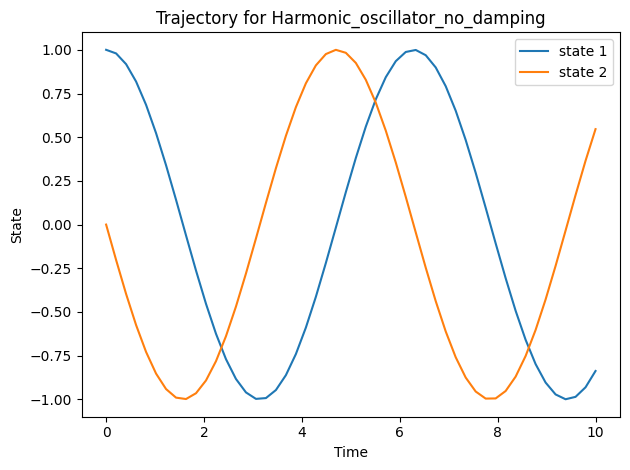

  4%|▎         | 1/28 [05:48<2:36:49, 348.51s/it]

Processing Harmonic_oscillator_damping...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0305 * x_1
x_1' = -1.0485 * x_0 + -9.2520 * (x_1)**5
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Error with layers [0, 2]: too many indices for array: array is 1-dimensional, but 2 were indexed
Found pretrained model at odeformer.pt
Loaded pretrained mo

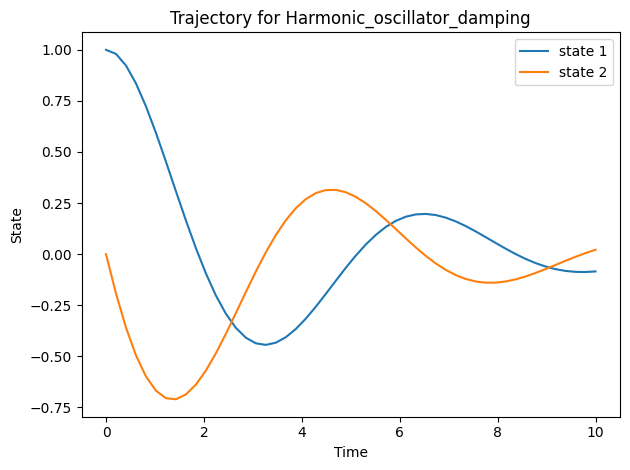

  7%|▋         | 2/28 [09:50<2:03:49, 285.74s/it]

Processing Lotka_Volterra_competition...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 0.9270 * x_0 + -0.0876 * x_0 * x_1
x_1' = -1.6038 * x_1 + 0.0803 * x_0 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained

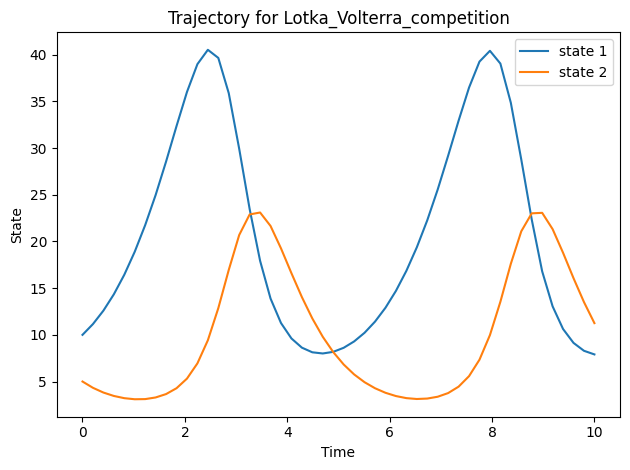

 11%|█         | 3/28 [13:09<1:42:36, 246.25s/it]

Processing Lotka_Volterra_simple...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.4427 * x_0 + -0.7994 * x_0 * x_1
x_1' = -3.5739 * x_1 + 1.6992 * x_0 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Error with layers [1]: too many indices for array: array is 1-dimensional, but 2 were indexed
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Error with layers [0, 2]: too many indices for

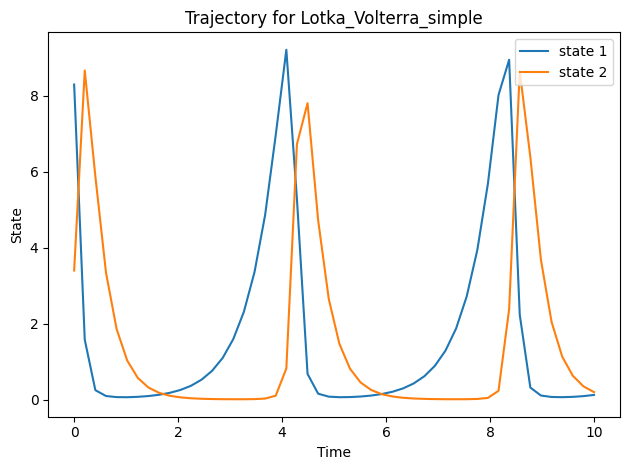

 14%|█▍        | 4/28 [16:59<1:35:57, 239.91s/it]

Processing Pendulum_no_friction...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0228 * x_1
x_1' = -8.7660 * x_0 + -88.6320 * (x_0)**3 * (0.0081 + -1.00000000000000 * x_1 * (-0.0554 + -0.2906 * x_1))**2
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Error with layers [0]: 'NoneType' object is not subscriptable
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Error with layers [0, 2]: 'NoneT

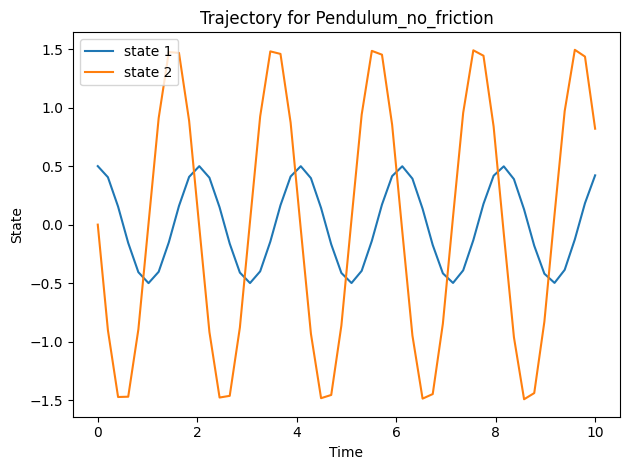

 18%|█▊        | 5/28 [22:24<1:43:40, 270.47s/it]

Processing Dipole_fixed_point...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -1.0413 * x_0 + 0.9450 * x_0 * x_1
x_1' = 0.9450 * x_1 + -0.9318 * x_0 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Skipping

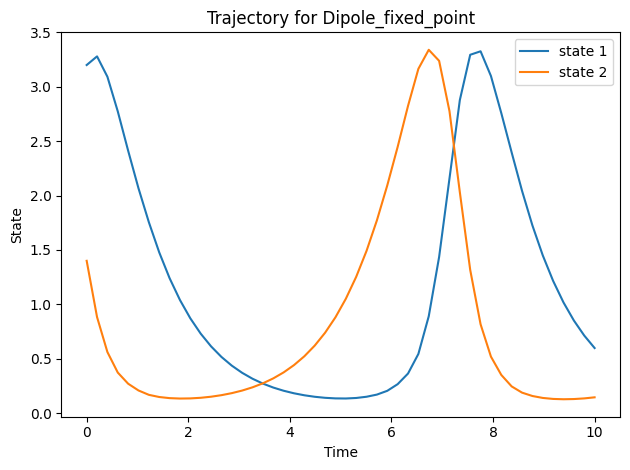

 21%|██▏       | 6/28 [25:35<1:29:17, 243.50s/it]

Processing RNA_replication...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 7.8502 * x_1 + -0.9486 * x_0 * (6.8333 * x_0 + 1.3500 * x_1)
x_1' = 0.6520 + -1.5507 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrai

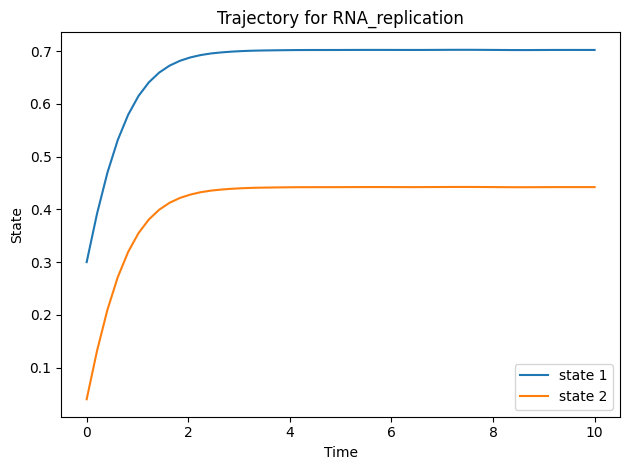

 25%|██▌       | 7/28 [29:57<1:27:22, 249.65s/it]

Processing SIR_model...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -0.3965 * x_0 * x_1
x_1' = -0.3226 * x_1 + 0.3894 * x_0 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Skipping encoder layer 2...


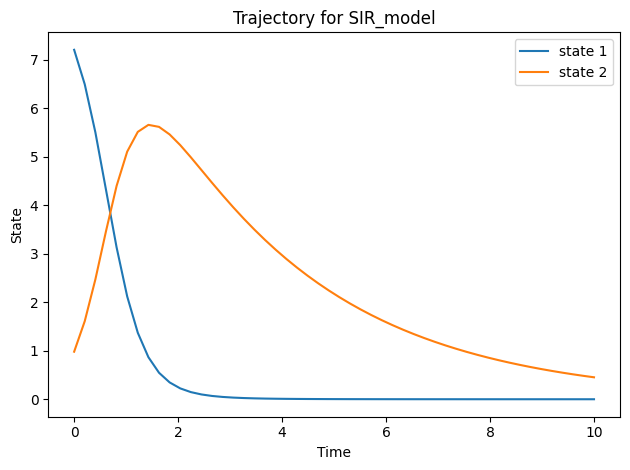

 29%|██▊       | 8/28 [32:27<1:12:39, 217.96s/it]

Processing Damped_double_well...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0395 * x_1
x_1' = 0.9540 * x_0 + 3.4670 * (x_0)**2 + -2.3058 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: too many indices for array: array is 1-dimensional, but 2 were indexed
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Lo

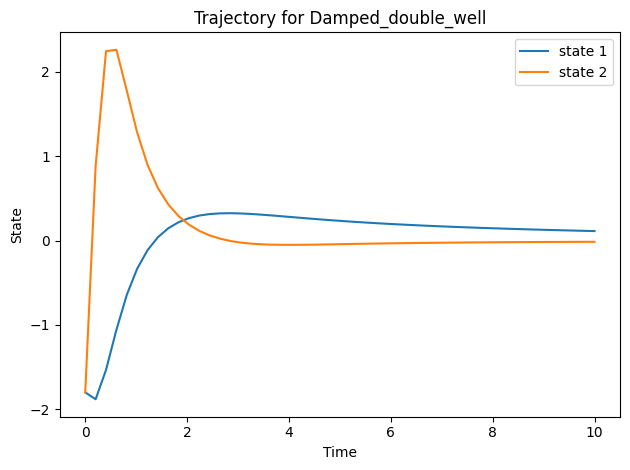

 32%|███▏      | 9/28 [35:27<1:05:11, 205.89s/it]

Processing Glider...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -0.2040 * x_0
x_1' = 1.2789 * x_0
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Error with layers [1, 2]: 'NoneType' object is not subscriptable
Found pretrain

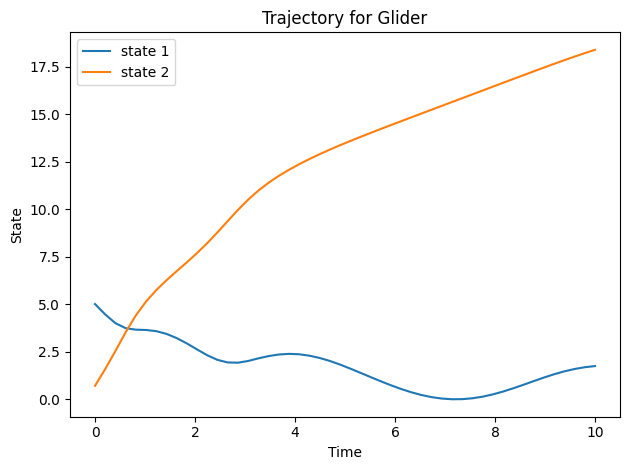

 36%|███▌      | 10/28 [38:40<1:00:34, 201.93s/it]

Processing Frictionless_bead...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -0.4294 * (x_0)**2
x_1' = 0.0003 * x_0 * (x_1)**2
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Error with layers [1, 2]: 'NoneType' object is not s

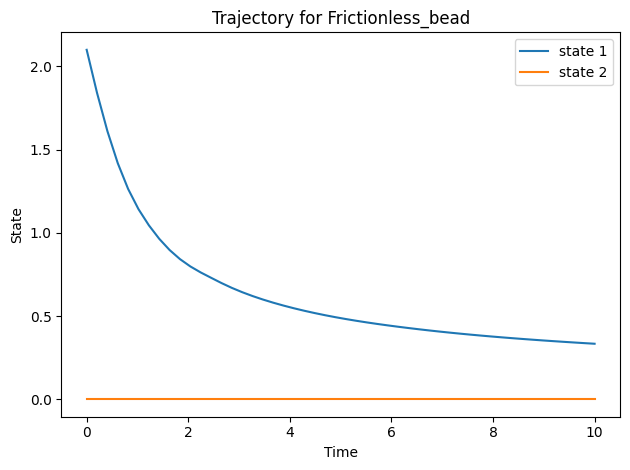

 39%|███▉      | 11/28 [41:19<53:28, 188.73s/it]  

Processing Rotational_dynamics...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0678 * (0.0505 + 1.3224 * x_1)**-1 + -0.3772 * (0.5763 + -1 * x_1)**2
x_1' = 0.8637 * x_0
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder lay

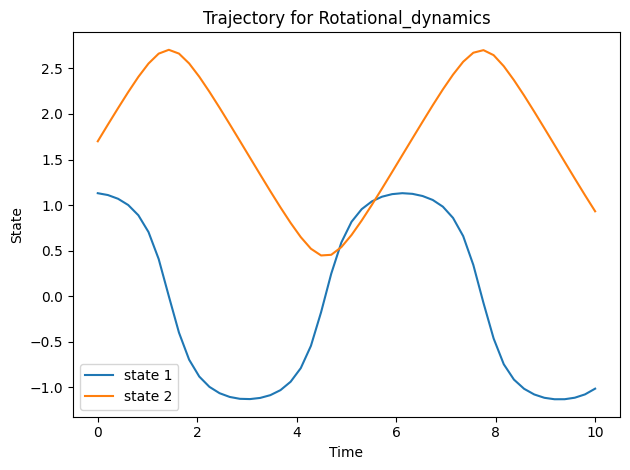

 43%|████▎     | 12/28 [45:56<57:32, 215.77s/it]

Processing Pendulum_nonlinear_damping...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0350 * x_1
x_1' = -0.9398 * x_0 + -0.9414 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Skipping encoder layer 2...

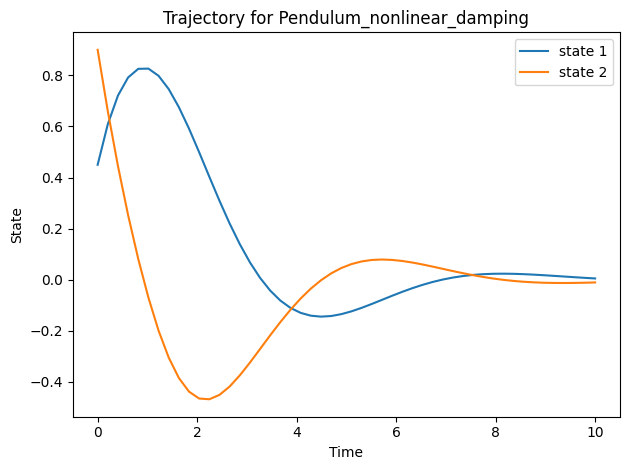

 46%|████▋     | 13/28 [48:08<47:33, 190.26s/it]

Processing Van_der_Pol_standard...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0084 * x_1 + -0.0567 * x_0
x_1' = -0.9196 * x_0 + -5.3714 * x_0 * x_1 * (0.0280 * x_0 + 0.0585 * x_1)
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: 'NoneType' object is not subscriptable
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Error with layers [1, 2]: 'NoneType'

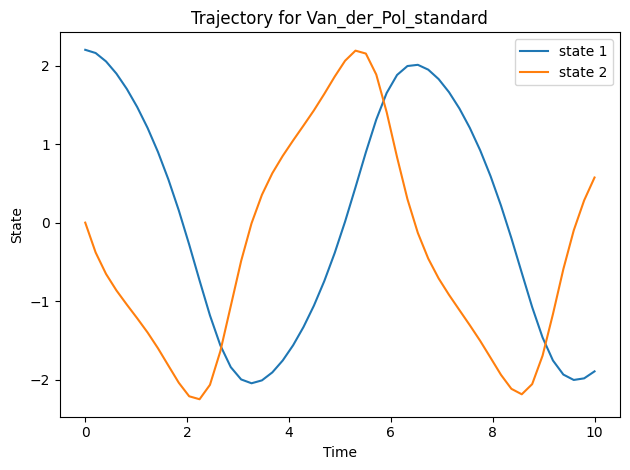

 50%|█████     | 14/28 [54:47<59:08, 253.48s/it]

Processing Van_der_Pol_simplified...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0099 * x_1 + -0.0481 * x_0
x_1' = 13.4820 * sin(-1.3130 + 1.5814 * x_0) + -6.1722 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found p

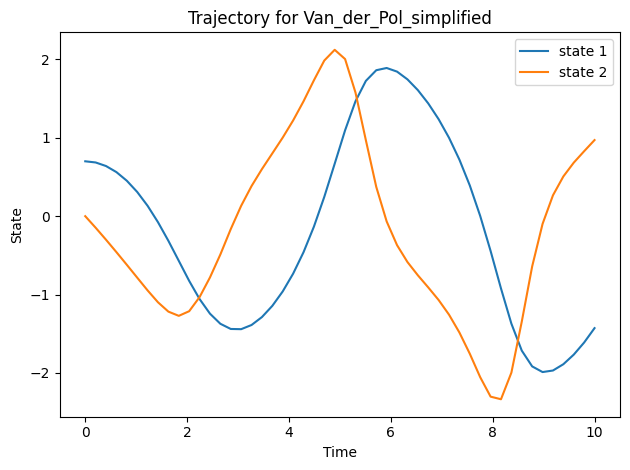

 54%|█████▎    | 15/28 [1:05:32<1:20:25, 371.22s/it]

Processing Glycolytic_oscillator...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 2.1842 * x_1 + -1.1142 * x_0
x_1' = 0.0551 + 0.6070 * x_1 + -2.2034 * x_0
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model a

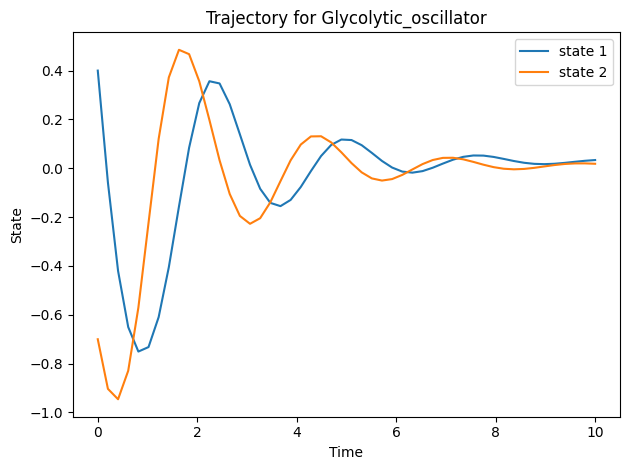

 57%|█████▋    | 16/28 [1:08:56<1:04:13, 321.10s/it]

Processing Duffing_equation...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0161 * x_1
x_1' = -0.6272 * x_1 + -1.0035 * x_0
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Skipping encoder layer 2...


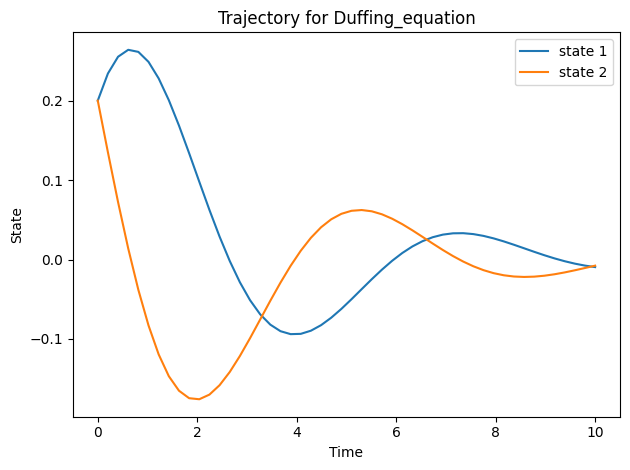

 61%|██████    | 17/28 [1:11:09<48:29, 264.54s/it]  

Processing Cell_cycle_tyson...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 8.4456 * sin(-1.3360 + 4.2500 * x_0) + -0.9450 * x_0
x_1' = -0.7048 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at ode

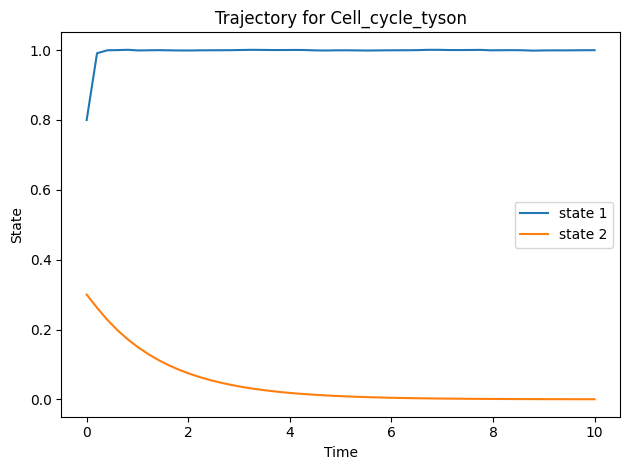

 64%|██████▍   | 18/28 [1:14:17<40:14, 241.43s/it]

Processing Chlorine_dioxide_model...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.8900 * (1 + -0.0529 * x_1)**2 + -5.5131 * x_1 + 6.6703 * x_1 * (1 + 0.3894 * x_1)**2
x_1' = 0.1617 * (x_1)**2 + -0.1605 * x_0 + -0.1385 * x_0 * (-0.8065 + -1 * x_1)**2
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Error with layers [0]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Error with layers [1]: 'NoneType' object is not subscriptable
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Error with layers [0, 1]: too many indices for array: array is 1-dimensional, but 2 were indexed
Found 

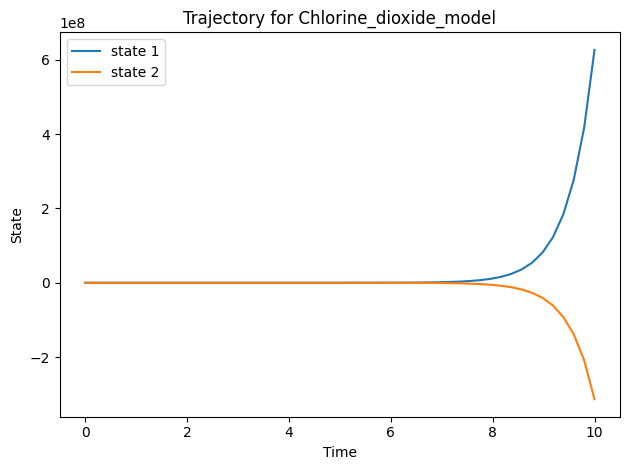

 68%|██████▊   | 19/28 [1:26:49<59:13, 394.82s/it]

Processing Driven_pendulum_linear...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0405 * x_1
x_1' = 0.0687 * x_1 + -0.9722 * sin(-16.2200 + 0.7680 * x_0)
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model 

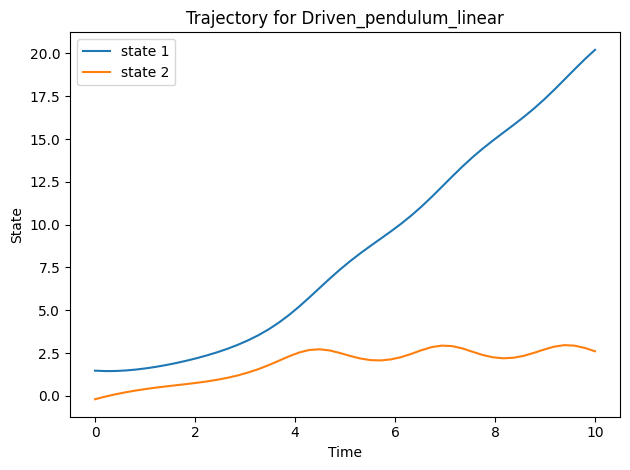

 71%|███████▏  | 20/28 [1:30:40<46:04, 345.60s/it]

Processing Driven_pendulum_quadratic...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.0247 * x_1
x_1' = -0.0062 * x_0 + -0.6615 * sin(-10.2600 + 0.8463 * x_0)
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained mo

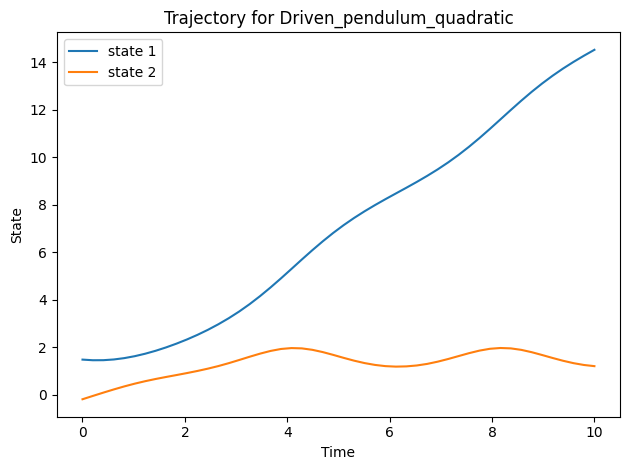

 75%|███████▌  | 21/28 [1:35:27<38:15, 327.97s/it]

Processing Isothermal_autocatalytic...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 0.3490 * x_1 + -0.5322 * x_1 * (x_0)**3
x_1' = -0.0284 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model at odeforme

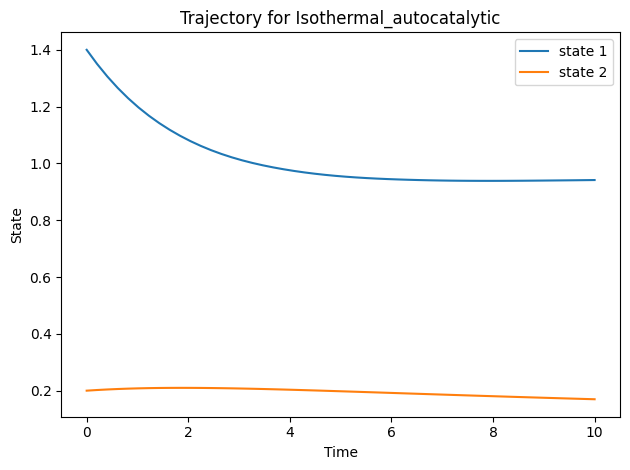

 79%|███████▊  | 22/28 [1:38:22<28:12, 282.13s/it]

Processing Interacting_bar_magnets...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -0.3460 * x_0 + -0.4918 * (x_0)**2
x_1' = -0.2752 * x_0 + -0.6035 * x_1
Found pretrained model at odeformer.pt
Loaded pretrained model
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 2...
Error with layers [2]: masked_fill_ only supports boolean masks, but got mask with dtype unsigned char
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 1...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 0...
Skipping encoder layer 2...
Found pretrained model at odeformer.pt
Loaded pretrained model
Skipping encoder layer 1...
Skipping encoder layer 2...
Found pretrained model a

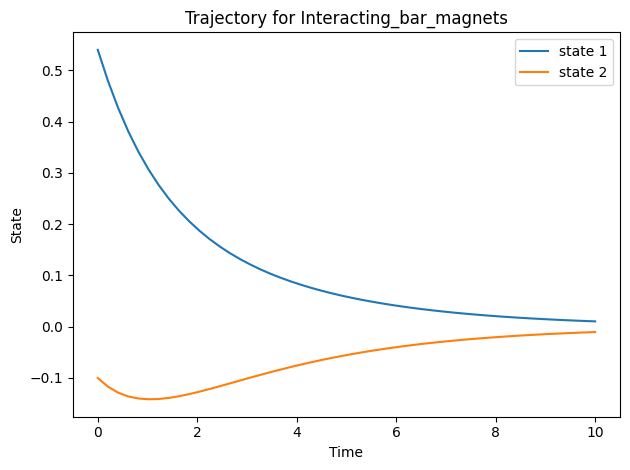

 82%|████████▏ | 23/28 [1:41:37<21:20, 256.04s/it]

Processing Binocular_rivalry...
Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = 1.2701 * x_1 + -1.2897 * x_0
x_1' = 1.0134 * x_1 + -1.8336 * (x_1)**2


In [ ]:
process_all_systems(systems_1d, "results/1d_systems")
# process_all_systems(systems_2d, "results/2d_systems")

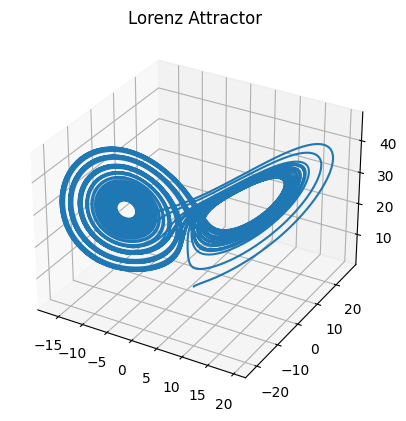

In [30]:
# 3D and 4D Systems

# 52. Maxwell–Bloch equations (laser dynamics)
def maxwell_bloch(t, state, delta=0.0, gamma=0.1, kappa=1.0):
    E, P, D = state
    dEdt = -kappa * E + delta * P
    dPdt = -gamma * P + delta * E * D
    dDdt = -delta * (E * P.conjugate()).real
    return [dEdt, dPdt, dDdt]

# 53. Model for apoptosis (cell death)
def apoptosis(t, state, k1=0.1, k2=0.1, k3=0.1):
    x, y, z = state
    dxdt = -k1 * x + k2 * y * z
    dydt = k1 * x - k2 * y * z - k3 * y**2
    dzdt = k3 * y**2
    return [dxdt, dydt, dzdt]

# 54-56. Lorenz equations
def lorenz(t, state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# 57-59. Rössler attractor
def rossler(t, state, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# 60. Aizawa attractor
def aizawa(t, state, a=0.95, b=0.7, c=0.6, d=3.5, e=0.25, f=0.1):
    x, y, z = state
    dxdt = (z - b) * x - d * y
    dydt = d * x + (z - b) * y
    dzdt = c + a * z - (z**3) / 3 - (x**2 + y**2) * (1 + e * z) + f * z * (x**3)
    return [dxdt, dydt, dzdt]

# 61. Chen–Lee attractor
def chen_lee(t, state, a=5, b=-10, c=-0.38):
    x, y, z = state
    dxdt = a * x - y * z
    dydt = b * y + x * z
    dzdt = c * z + x * y / 3
    return [dxdt, dydt, dzdt]

# Define 4D Systems

# 62. SEIR infection model (proportions)
def seir(t, state, beta=0.3, sigma=0.1, gamma=0.05):
    S, E, I, R = state
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# 63. Cart–Pole (inverted pendulum)
def cart_pole(t, state, g=9.81, m=1.0, M=5.0, L=2.0, u=0.0):
    x, x_dot, theta, theta_dot = state
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    total_mass = m + M
    pole_mass_length = m * L
    temp = (u + pole_mass_length * theta_dot**2 * sin_theta) / total_mass
    theta_acc = (g * sin_theta - cos_theta * temp) / (L * (4/3 - m * cos_theta**2 / total_mass))
    x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass
    return [x_dot, x_acc, theta_dot, theta_acc]

# Dictionary for all 3D systems
system_3d = {
    "maxwell_bloch": maxwell_bloch,
    "apoptosis": apoptosis,
    "lorenz": lorenz,
    "rossler": rossler,
    "aizawa": aizawa,
    "chen_lee": chen_lee
}

# Dictionary for all 4D systems
system_4d = {
    "seir": seir,
    "cart_pole": cart_pole
}

def generate_trajectory(system, initial_state, t_span=(0, 50), num_points=10000):
    t_eval = np.linspace(t_span[0], t_span[1], num_points)
    solution = solve_ivp(system, t_span, initial_state, t_eval=t_eval)
    return solution.t, solution.y

# Example of generating data for all systems
trajectories_3d = {name: generate_trajectory(system, [1.0, 1.0, 1.0]) for name, system in system_3d.items()}
trajectories_4d = {name: generate_trajectory(system, [1.0, 1.0, 1.0, 1.0]) for name, system in system_4d.items()}

# Plotting example for Lorenz system
t, traj = trajectories_3d["lorenz"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[0], traj[1], traj[2])
ax.set_title("Lorenz Attractor")
plt.show()

In [12]:
!zip -r results.zip results

updating: results/ (stored 0%)
updating: results/1d_systems/ (stored 0%)
updating: results/1d_systems/Landau_equation/ (stored 0%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_7.png (deflated 24%)
updating: results/1d_systems/Landau_equation/Landau_equation_encoder_attn_layer_3.png (deflated 16%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_8.png (deflated 24%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_2.png (deflated 26%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_6.png (deflated 25%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_9.png (deflated 25%)
updating: results/1d_systems/Landau_equation/Landau_equation_encoder_ablation.png (deflated 10%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer_5.png (deflated 25%)
updating: results/1d_systems/Landau_equation/Landau_equation_cross_attn_layer